# DT8122 - Assignment

<span style="color:red">Deadline: 2023 August 15 AoE (Anywhere on Earth)</span>

Send a zip file with the notebook both as a .ipynb and as a .pdf file to <a href="mailto:dt8122@idi.ntnu.no">dt8122@idi.ntnu.no</a>. Label the file with your full name.

The task is to implement conditional DDPM for MNIST images. Your implementation should take as input a digit and be able to generate 28x28 grayscale handwritten image of said digit.

You can add additional cells anywhere in the notebook to make your code more readable.

DDPM: https://arxiv.org/abs/2006.11239

Classifier-free conditional DDPM: https://arxiv.org/abs/2207.12598

The notebook should be run when it is turned in so all plots are visible. All code should be contained in the notebook.

### Disclaimer:
Parts of my code are inspired by the code from the following medium articles:
"Generating images with DDPMs: A PyTorch Implementation" by Brian Pulfer
and
"Class conditioned diffusion models using Keras and TensorFlow" by Vedant Jumle


### Install necessary libraries
Any additional libraries you make use of should be installed in this cell.

In [1]:
!pip install torch
!pip install matplotlib
!pip install torchvision
!pip install tqdm
!pip install numpy


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


### Import libraries
All import statements should be contained here.

In [2]:
import random
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST
import torch
import math
import torch.nn as nn

### Define constants here
Constants such as number of epochs, device, and learning rate and other hyperparameters should be defined here.

In [3]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
batch_size = 64
lr = 1e-3
nb_epochs = 30
p_cond=0.1 # values from paper
guidance_strength=1 # Somewhere in the middle from values in paper

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device='cpu' #for debugging
print(f'Using device "{device}"')

#forward parameters:
nb_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02
betas = torch.linspace(min_beta, max_beta, nb_steps).to(
    device)
alphas = 1 - betas
alpha_bars = torch.tensor([torch.prod(alphas[:i + 1]) for i in range(len(alphas))]).to(device)




Using device "cuda"


### Functionality for loading and visualizing dataset
We have provided some functionality for loading and visualizing the dataset. You may add more cells/functions here.

In [4]:
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
dataset = MNIST("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

In [5]:
"""
This function plots images in a grid. Input is a Tensor.
See show_first_batch to see how it is used.
"""
def show_images(images, title=""):
    images = images.detach().cpu().numpy()
    fig = plt.figure(figsize=(4, 4))
    cols = math.ceil(len(images) ** (1 / 2))
    rows = math.ceil(len(images) / cols)
    for r in range(rows):
        for c in range(cols):
            idx = cols * r + c
            ax = fig.add_subplot(rows, cols, idx + 1)
            ax.axis('off')
            if idx < len(images):
                ax.imshow(images[idx][0], cmap="gray")
    fig.suptitle(title, fontsize=18)
    plt.show()

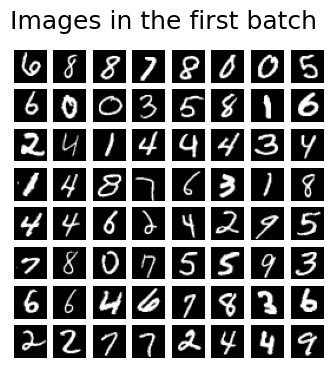

In [6]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break
show_first_batch(loader)

### Your conditional DDPM implementation should go here
This includes functionality for adding noise to the image.

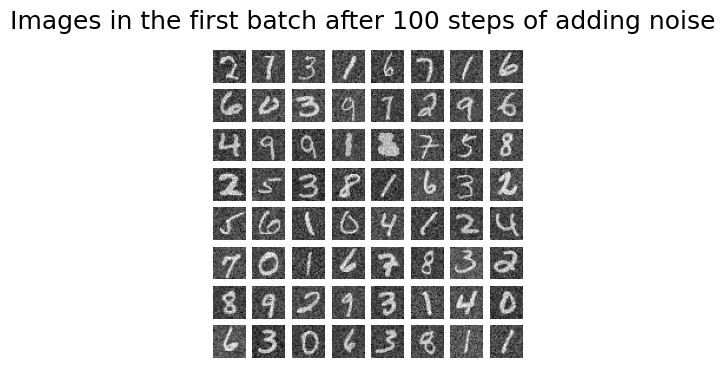

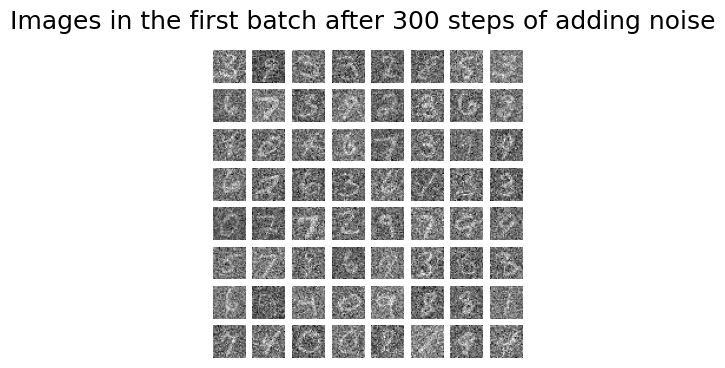

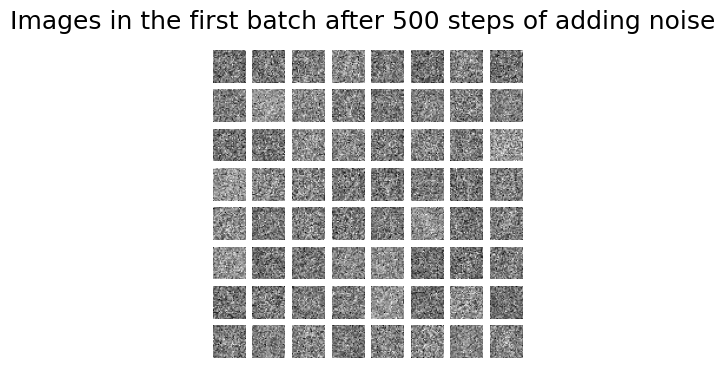

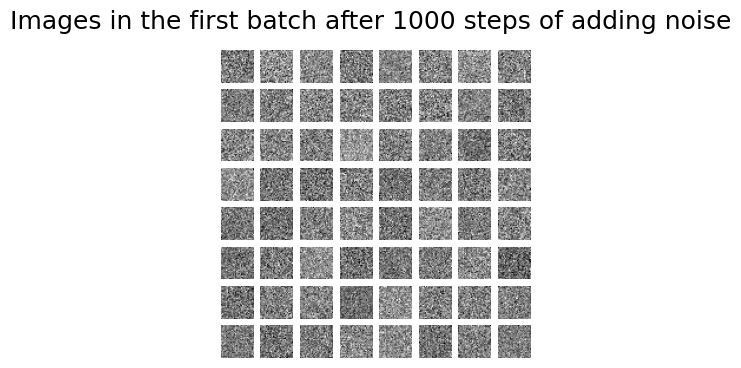

In [7]:

def ddpm_forward(x0, t, eta=None):
    n, c, h, w = x0.shape
    a_bar = alpha_bars[t]
    if eta is None:
        eta = torch.randn(n, c, h, w).to(device)
    noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
    return noisy

def show_noisy_first_batch(loader,value):
    for batch in loader:
        imgs=batch[0].to(device)
        time=torch.tensor(int(value*nb_steps)-1)
        time = time.repeat(len(imgs)).to(device)
        noisy=ddpm_forward(imgs,time)
        show_images(noisy, "Images in the first batch after " +str(int(value*nb_steps))+" steps of adding noise")
        break
show_noisy_first_batch(loader,0.1)
show_noisy_first_batch(loader,0.3)
show_noisy_first_batch(loader,0.5)
show_noisy_first_batch(loader,1)





### The implementation of the neural network used to estimate the noise should go here
The network should make use of both time and context embedding.

Any functions/methods used for time and context embeddings should also go here.

In [8]:
class conv_block(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(conv_block, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.Mish() if activation is None else activation
        self.normalize = normalize
        self.in_c=in_c
        self.out_c=out_c

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out


def sinusoidal_embedding(n, d):
    # Sinusoidal positional encoding from the paper "Attention is all you need"
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])
    return embedding


class ClassConditioning(nn.Module):
    def __init__(self, indim,outdim, num_channels=1):
        super(ClassConditioning, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(indim * num_channels, outdim * outdim * num_channels),
            nn.Mish()
        )
        self.outdim = outdim
        self.num_channels = num_channels

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.block(x)
        x = x.view(-1,  self.num_channels,self.outdim, self.outdim)
        return x

class conditinal_UNet(nn.Module):
    # a basic UNet implementation with class conditioning at each layer
    def __init__(self, n_steps=1000, time_emb_dim=100,num_classes=10,class_emb_dim=64
                 ,latent_sizes=[1,32,64,128],spatial_sizes=[28,14,7,3]):
        super(conditinal_UNet, self).__init__()

        self.class_embedd = nn.Embedding(num_classes, class_emb_dim)
        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # downs
        latent_sizes_cond = latent_sizes.copy()
        class_cond_layers = []
        for i in range(len(latent_sizes)):
            latent_sizes_cond[i]+=1
            class_cond_layers.append(ClassConditioning(indim=class_emb_dim,outdim=spatial_sizes[i]))

        self.down_blocks= nn.ModuleList()
        self.downs= nn.ModuleList()
        self.time_embeds_down= nn.ModuleList()
        self.class_conditionals_down= nn.ModuleList()

        for i in range(len(latent_sizes)-1):
            latent_size_cond=latent_sizes_cond[i]
            latent_size=latent_sizes[i+1]
            spatial_size=spatial_sizes[i]
            block=nn.Sequential(
                            conv_block((latent_size_cond, spatial_size, spatial_size), latent_size_cond, latent_size),
                            conv_block((latent_size, spatial_size, spatial_size), latent_size, latent_size),
                            conv_block((latent_size, spatial_size, spatial_size), latent_size, latent_size)
                        )
            down= nn.Conv2d(latent_size, latent_size, 4, 2, 1)
            time_embed = self.lin_with_act(time_emb_dim, latent_size_cond)
            self.down_blocks.append(block)
            self.time_embeds_down.append(time_embed)
            self.downs.append(down)
            class_cond=ClassConditioning(indim=class_emb_dim,outdim=spatial_size)
            self.class_conditionals_down.append(class_cond)

        #mid
        latent_size_cond_mid=latent_sizes_cond[-1]
        latent_size_mid=latent_sizes[-1]
        spatial_size_mid=spatial_sizes[-1]
        self.class_cond_mid=ClassConditioning(indim=class_emb_dim,outdim=spatial_size_mid)
        self.time_embed_mid = self.lin_with_act(time_emb_dim, latent_size_cond_mid)

        self.mid_block=nn.Sequential(
                            conv_block((latent_size_cond_mid, spatial_size_mid, spatial_size_mid), latent_size_cond_mid, latent_size_mid),
                            conv_block((latent_size_mid, spatial_size_mid, spatial_size_mid), latent_size_mid, latent_size_mid),
                            conv_block((latent_size_mid, spatial_size_mid, spatial_size_mid), latent_size_mid, latent_size_mid)
                        )

        #ups
        self.up_blocks= nn.ModuleList()
        self.ups= nn.ModuleList()
        self.time_embeds_up= nn.ModuleList()
        self.class_conditionals_up= nn.ModuleList()
        for i in range(len(latent_sizes)-1,0,-1):
            latent_size_prev=latent_sizes[i]
            if i==1:
                latent_size=latent_sizes[i]
            else:
                latent_size = latent_sizes[i-1]
            spatial_size=spatial_sizes[i-1]
            if i==len(latent_sizes)-1:
                up = nn.Sequential(
                    nn.ConvTranspose2d(latent_size_prev, latent_size_prev, 4, 2, 1),
                    nn.Mish(),
                    nn.ConvTranspose2d(latent_size_prev, latent_size_prev, 2, 1)
                )
            else:
                up = nn.ConvTranspose2d(latent_size_prev, latent_size_prev, 4, 2, 1)
            latent_size_cond = 2*latent_sizes[i]
            latent_size_cond=latent_size_cond+1
            block = nn.Sequential(
                conv_block((latent_size_cond, spatial_size, spatial_size), latent_size_cond, latent_size),
                conv_block((latent_size, spatial_size, spatial_size), latent_size, latent_size),
                conv_block((latent_size, spatial_size, spatial_size), latent_size, latent_size)
            )
            self.ups.append(up)
            self.up_blocks.append(block)
            time_embed = self.lin_with_act(time_emb_dim, latent_size_cond)
            self.time_embeds_up.append(time_embed)
            class_conditional = ClassConditioning(indim=class_emb_dim, outdim=spatial_size)
            self.class_conditionals_up.append(class_conditional)
        # final
        self.final_conv = nn.Conv2d(latent_sizes[1], 1, 3, 1, 1)

    def forward(self, x, t,classes):
        class_emedding = self.class_embedd(classes)
        t = self.time_embed(t)
        n = len(x)
        outs = []
        # down
        for i in range(len(self.down_blocks)):
            class_conditional = self.class_conditionals_down[i]
            cv = class_conditional(class_emedding)
            x = torch.cat([x, cv], dim=1)
            x = self.down_blocks[i](x + self.time_embeds_down[i](t).reshape(n, -1, 1, 1))
            outs.append(x)
            x = self.downs[i](x)

        # mid
        cv_mid = self.class_cond_mid(class_emedding)
        x = torch.cat([x, cv_mid], dim=1)
        x= self.mid_block(x + self.time_embed_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        # up
        for j in range(len(self.up_blocks)):
            up = self.ups[j]
            x=up(x)
            res_out= outs[-(j + 1)]
            x = torch.cat((x, res_out), dim=1)
            cv_up = self.class_conditionals_up[j](class_emedding)
            x = torch.cat([x, cv_up], dim=1)
            x = self.up_blocks[j](x + self.time_embeds_up[j](t).reshape(n, -1, 1, 1))

        # final
        out = self.final_conv(x)

        return out

    def lin_with_act(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )
# forward neural network parameters:
model=conditinal_UNet(nb_steps).to(device)

### Show that you can generate images before the model is trained
This should demonstrate that the backwards pass works. The generated images are expected to be noise.

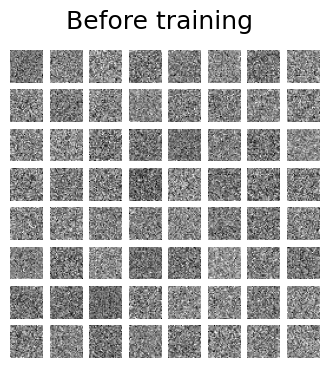

In [9]:
def generate_new_images(network, n_samples=64, c=1, h=28, w=28,
                        gen_class=7,guidance_strength=1):
    with torch.no_grad():
        x = torch.randn(n_samples, c, h, w).to(device)
        # initialise class vector as ad tensor of length n_samples and value gen_class as integer
        class_vector = torch.ones(n_samples, dtype=torch.long) * gen_class
        class_vector = class_vector.to(device)

        for idx, t in enumerate(list(range(nb_steps))[::-1]):
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            # Estimate noise
            #linear interpolation between eta output of two networks
            eta_theta1 = network(x, time_tensor,class_vector)
            # set class vector to all zeros
            class_vector_zeros = torch.zeros(n_samples, dtype=torch.long).to(device)
            eta_theta2 = network(x, time_tensor,class_vector_zeros)
            eta_theta= (1+guidance_strength)*eta_theta1-guidance_strength*eta_theta2
            #eta_theta=eta_theta1
            alpha_t = alphas[t]
            alpha_t_bar = alpha_bars[t]
            # Denoise
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)
            # add extra noise
            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)
                beta_t = betas[t]
                sigma_t = beta_t.sqrt()
                x = x + sigma_t * z
    return x



generated=generate_new_images(model)
show_images(generated, title='Before training')

### Implement training loop
Train the model here. There should be some indication of how long the model took to train, both total and per epoch. For good results you will want to train the model for several epochs, but with a good implementation you should expect to see something that looks like digits after only a single epoch.

Training progress:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/938 [00:00<?, ?it/s]

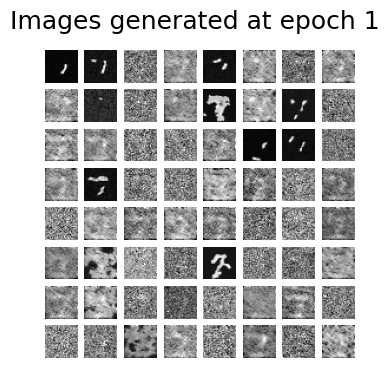

Loss at epoch 1: 0.064
loss improved from inf


Epoch 2/30:   0%|          | 0/938 [00:00<?, ?it/s]

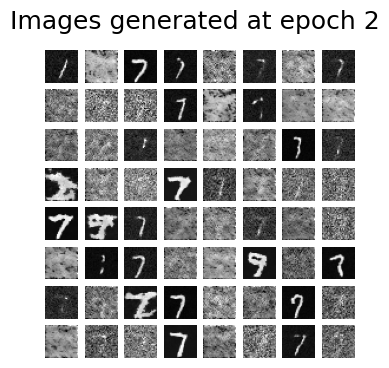

Loss at epoch 2: 0.034
loss improved from 0.06391815164287898


Epoch 3/30:   0%|          | 0/938 [00:00<?, ?it/s]

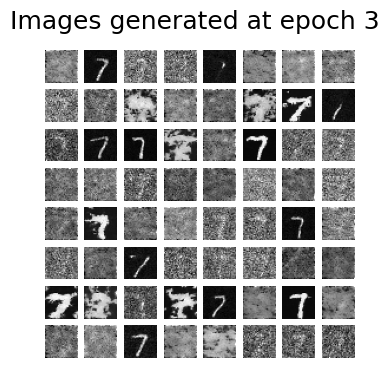

Loss at epoch 3: 0.031
loss improved from 0.03361574090917906


Epoch 4/30:   0%|          | 0/938 [00:00<?, ?it/s]

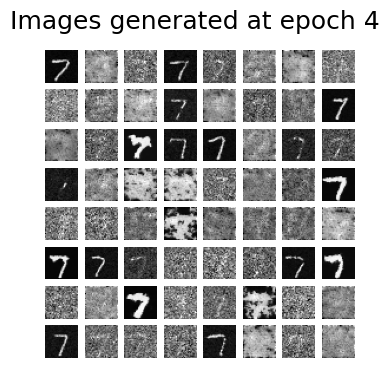

Loss at epoch 4: 0.029
loss improved from 0.03083812756737077


Epoch 5/30:   0%|          | 0/938 [00:00<?, ?it/s]

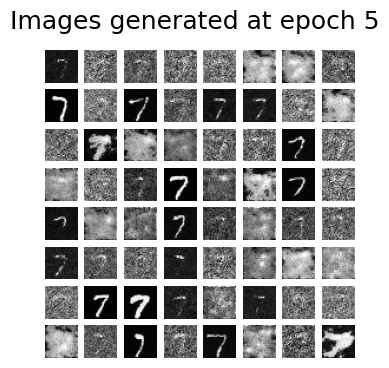

Loss at epoch 5: 0.028
loss improved from 0.029204874829451218


Epoch 6/30:   0%|          | 0/938 [00:00<?, ?it/s]

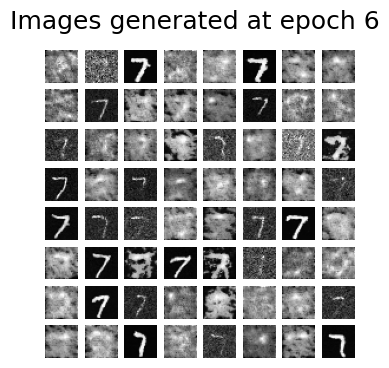

Loss at epoch 6: 0.028
loss improved from 0.02822791676024598


Epoch 7/30:   0%|          | 0/938 [00:00<?, ?it/s]

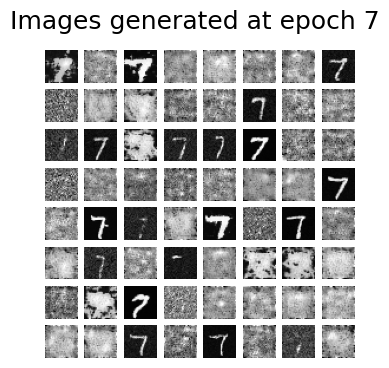

Loss at epoch 7: 0.027
loss improved from 0.027826346025864243


Epoch 8/30:   0%|          | 0/938 [00:00<?, ?it/s]

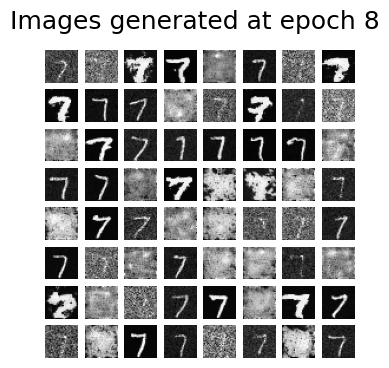

Loss at epoch 8: 0.027
loss improved from 0.027128653260072074


Epoch 9/30:   0%|          | 0/938 [00:00<?, ?it/s]

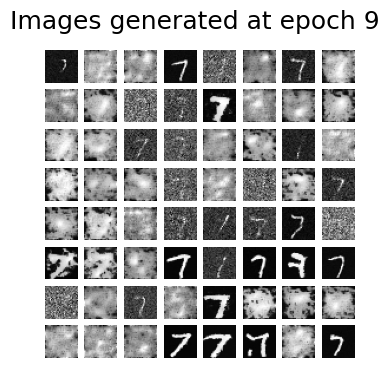

Loss at epoch 9: 0.026
loss improved from 0.026549980673193918


Epoch 10/30:   0%|          | 0/938 [00:00<?, ?it/s]

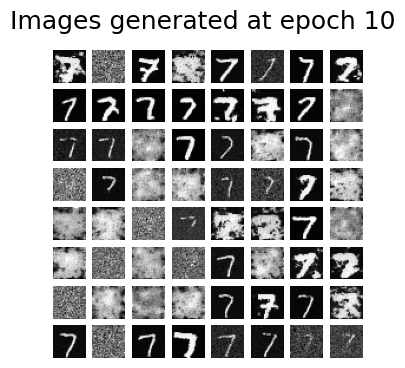

Loss at epoch 10: 0.026
loss improved from 0.026250158231457068


Epoch 11/30:   0%|          | 0/938 [00:00<?, ?it/s]

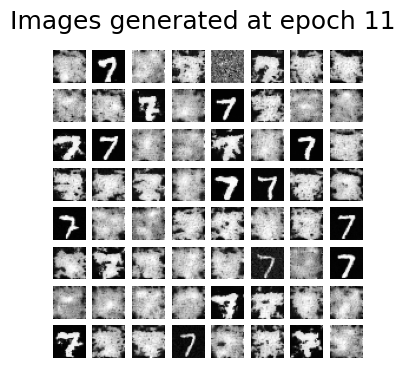

Loss at epoch 11: 0.025
loss improved from 0.026035176492730763


Epoch 12/30:   0%|          | 0/938 [00:00<?, ?it/s]

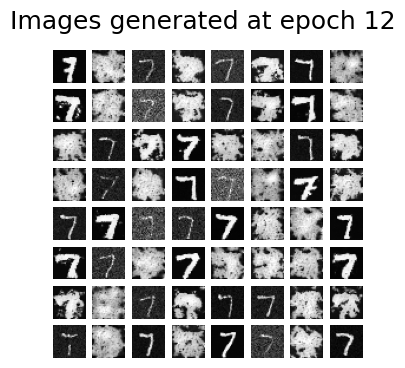

Loss at epoch 12: 0.025
loss improved from 0.025450180262327187


Epoch 13/30:   0%|          | 0/938 [00:00<?, ?it/s]

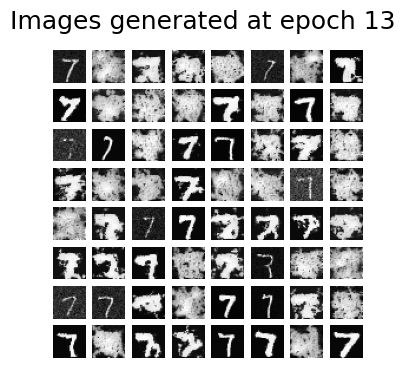

Loss at epoch 13: 0.025
loss did not improve from 0.02537891936898233


Epoch 14/30:   0%|          | 0/938 [00:00<?, ?it/s]

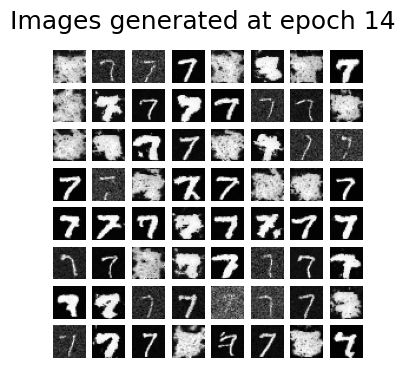

Loss at epoch 14: 0.025
loss improved from 0.02537891936898233


Epoch 15/30:   0%|          | 0/938 [00:00<?, ?it/s]

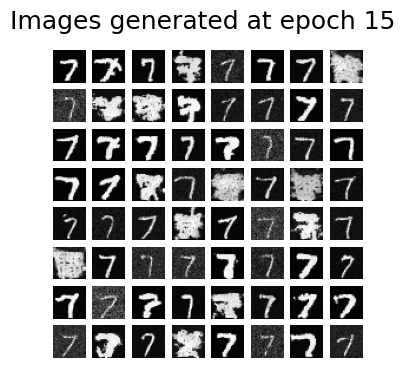

Loss at epoch 15: 0.025
loss improved from 0.02519758393267791


Epoch 16/30:   0%|          | 0/938 [00:00<?, ?it/s]

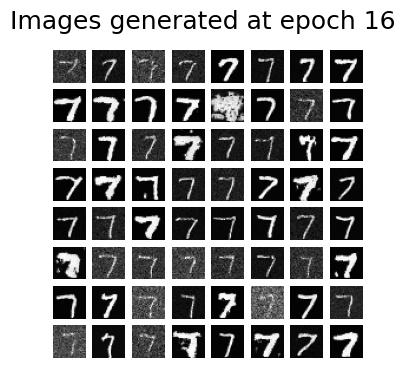

Loss at epoch 16: 0.025
loss improved from 0.0251838347832362


Epoch 17/30:   0%|          | 0/938 [00:00<?, ?it/s]

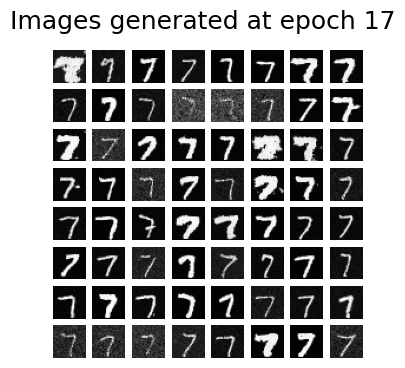

Loss at epoch 17: 0.025
loss improved from 0.025010514178872085


Epoch 18/30:   0%|          | 0/938 [00:00<?, ?it/s]

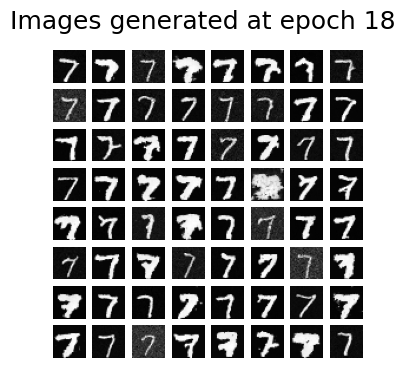

Loss at epoch 18: 0.025
loss improved from 0.024611763559778514


Epoch 19/30:   0%|          | 0/938 [00:00<?, ?it/s]

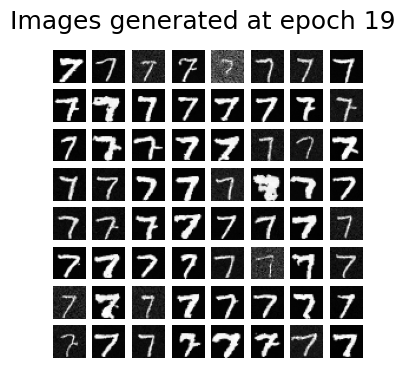

Loss at epoch 19: 0.024
loss improved from 0.024609707172711666


Epoch 20/30:   0%|          | 0/938 [00:00<?, ?it/s]

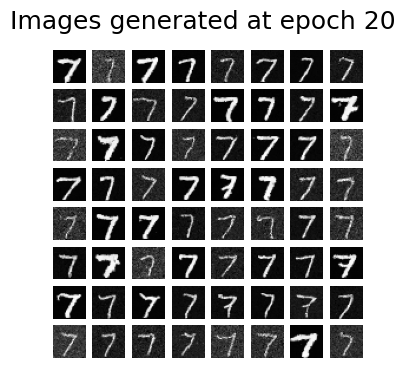

Loss at epoch 20: 0.024
loss did not improve from 0.024263686992724742


Epoch 21/30:   0%|          | 0/938 [00:00<?, ?it/s]

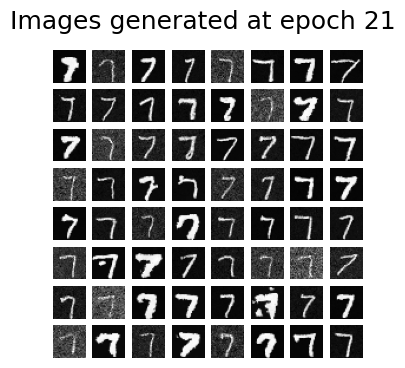

Loss at epoch 21: 0.025
loss did not improve from 0.024263686992724742


Epoch 22/30:   0%|          | 0/938 [00:00<?, ?it/s]

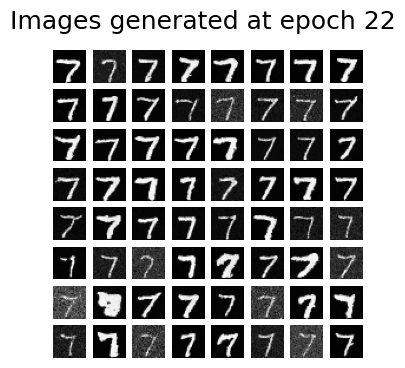

Loss at epoch 22: 0.024
loss improved from 0.024263686992724742


Epoch 23/30:   0%|          | 0/938 [00:00<?, ?it/s]

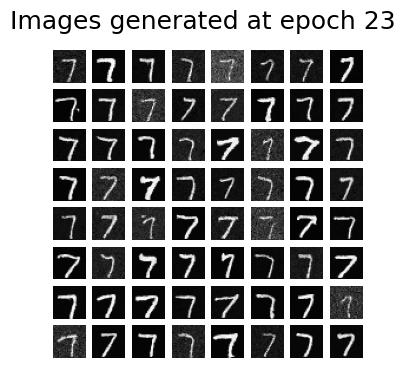

Loss at epoch 23: 0.024
loss did not improve from 0.0240362176855405


Epoch 24/30:   0%|          | 0/938 [00:00<?, ?it/s]

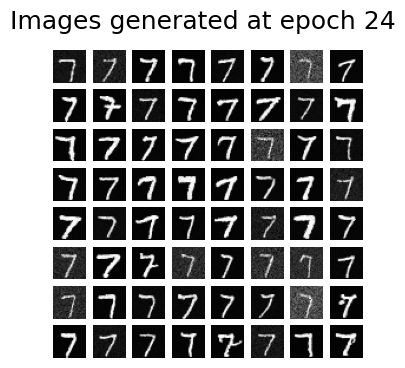

Loss at epoch 24: 0.024
loss did not improve from 0.0240362176855405


Epoch 25/30:   0%|          | 0/938 [00:00<?, ?it/s]

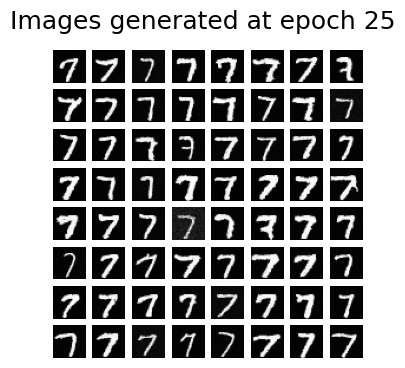

Loss at epoch 25: 0.024
loss did not improve from 0.0240362176855405


Epoch 26/30:   0%|          | 0/938 [00:00<?, ?it/s]

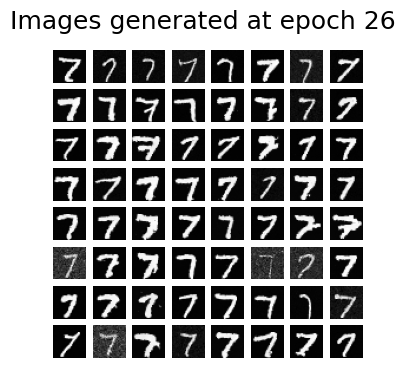

Loss at epoch 26: 0.024
loss improved from 0.0240362176855405


Epoch 27/30:   0%|          | 0/938 [00:00<?, ?it/s]

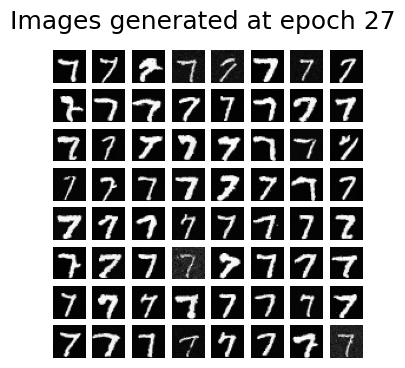

Loss at epoch 27: 0.024
loss improved from 0.023998738763729738


Epoch 28/30:   0%|          | 0/938 [00:00<?, ?it/s]

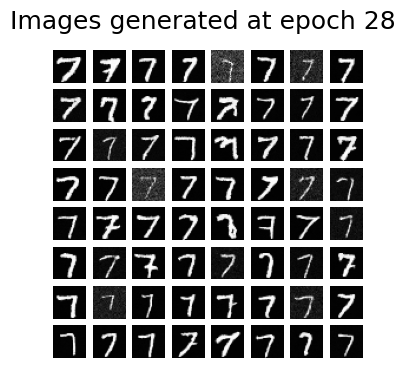

Loss at epoch 28: 0.024
loss improved from 0.023864673124750463


Epoch 29/30:   0%|          | 0/938 [00:00<?, ?it/s]

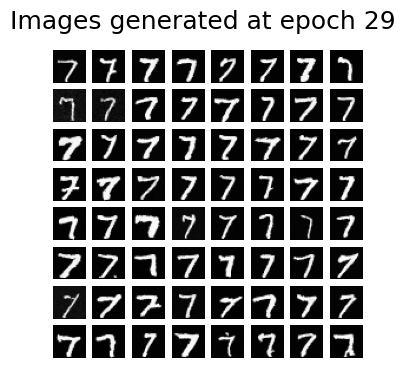

Loss at epoch 29: 0.024
loss did not improve from 0.023546949692567237


Epoch 30/30:   0%|          | 0/938 [00:00<?, ?it/s]

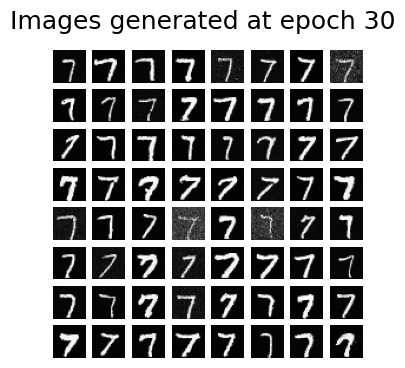

Loss at epoch 30: 0.024
loss did not improve from 0.023546949692567237


In [10]:
def train(network, loader, nb_epochs, optim, device, verbose=False,p_cond=0.1,guidance_strength=1):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = nb_steps
    for epoch in tqdm(range(nb_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{nb_epochs}", colour="#005500")):
            x0 = batch[0].to(device)
            classes=batch[1].to(device)
            # generate random number between 0 and 1. If smaller than p_cond, then we do not use the conditional and set classes to 0
            classes_copy=classes.clone()
            if random.random()<p_cond:
                classes_copy=torch.zeros_like(classes_copy)
            n = len(x0)
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)
            noisy_imgs = ddpm_forward(x0, t, eta)
            eta_theta = network(noisy_imgs, t.reshape(n, -1),classes_copy)
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()
            epoch_loss += loss.item() * len(x0) / len(loader.dataset)
        if verbose:
            show_images(generate_new_images(network,guidance_strength=guidance_strength), f"Images generated at epoch {epoch + 1}")
        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"
        if best_loss > epoch_loss:
            log_string += "\nloss improved from " + str(best_loss)
            best_loss = epoch_loss
        else:
            log_string += "\nloss did not improve from " + str(best_loss)
        if verbose:
            print(log_string)


optim = torch.optim.Adam(model.parameters(), lr=lr)
train(model,loader, nb_epochs, optim, device, verbose=True,p_cond=p_cond,guidance_strength=guidance_strength)

# At each epoch I show how the generated images look like for class 7

### Train and visualize the model
We want to see several generated examples of each digit.

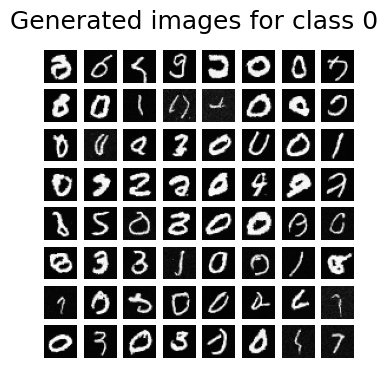

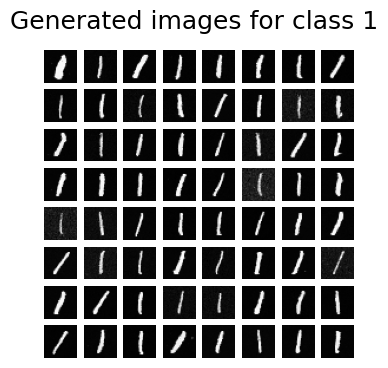

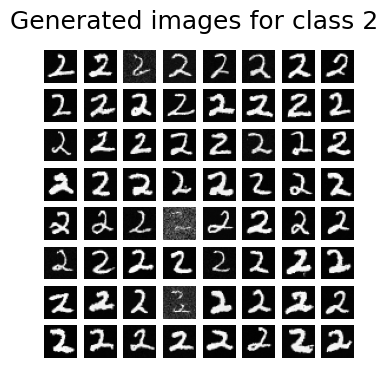

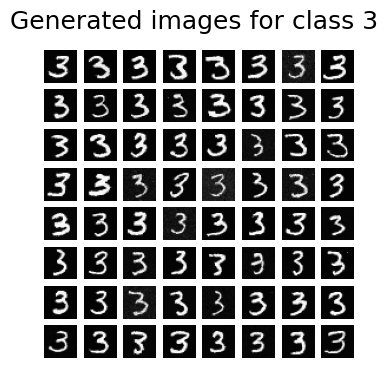

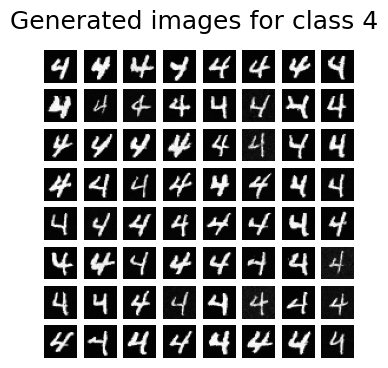

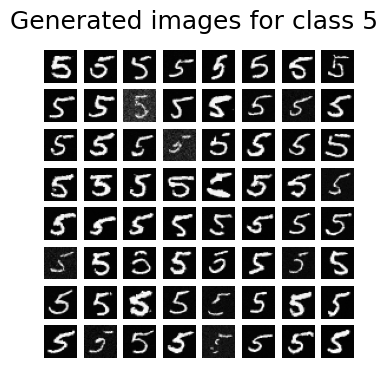

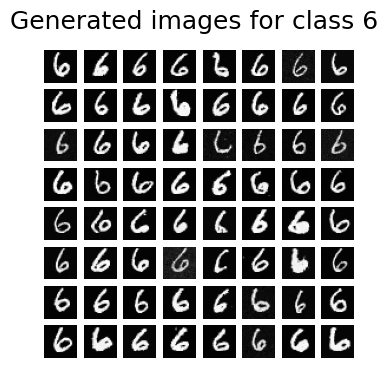

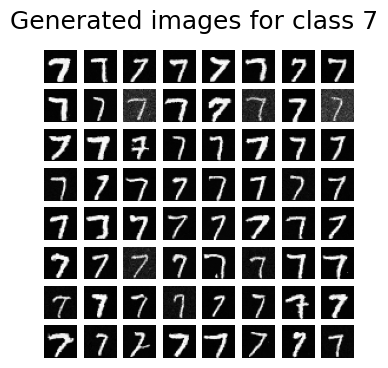

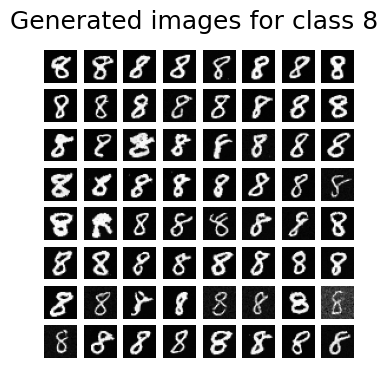

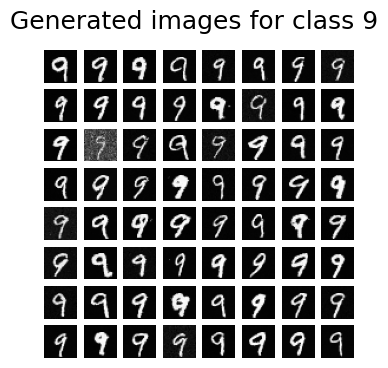

In [11]:
# Now I show 1 batch of generated images for each class

for cls in range(10):
    generated = generate_new_images(
            network=model,
            gen_class=cls,
            guidance_strength=guidance_strength
        )
    show_images(generated, title=f"Generated images for class {cls}")